# IMAGE RECOGNITION CLASSIFIER
<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

In [1]:
import io
import cv2
import sys
import json
import random
import os, signal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import _pickle as pickle
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

#if not TF 2.x installed
#tf.enable_eager_execution()

from functions import (func_jsonParser,
                       func_TrainValidationTest_Splitter,
                       custom_Callback_sparse)

#-----------------------------------------------------------------------------------------------------------------#

#Main Python/module versions used here for reference
print('python:', sys.version, '\n')
print('pandas:    ', pd.__version__)
print('seaborn:   ', sns.__version__)
print('numpy:     ', np.__version__)
print('matplotlib:', mpl.__version__)
print('json:      ', json.__version__)
print('tensorflow:', tf.__version__)
print('keras:     ', keras.__version__)

tf.keras.backend.clear_session()

#-----------------------------------------------------------------------------------------------------------------#

#import warnings
#warnings.filterwarnings('ignore')

python: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

pandas:     0.25.0
seaborn:    0.9.0
numpy:      1.16.4
matplotlib: 3.1.0
json:       2.0.9
tensorflow: 2.0.0-beta1
keras:      2.2.4-tf


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### MAIN CUSTOMIZABLE VARIABLES

In [2]:
PHOTOS_PATHDIR = 'yelp_photos/' #=> (str) path of the data (in this case, photos).

CLASSES_NUM = 3                 #=> (int) {5 or 3} if CLASSES_NUM=5 the five clases are considered for classification,
                                # if CLASSES_NUM=3 the classes "inside" and "outside" are removed for classification.

VERBOSE = True                  #=> (boolean) show or not additional information.

TEST_PERCENTANGE = 0.50         #=> (float) percentage of records to be used for training/validation and test.
                                # COMMENT: a high value can be used to reduce the load during training for ilustrative
                                #          purposes in this exercise.
    
TRAINING_PERCENTANGE = 0.75     #=> (float) percentage of training and validation records with respect to the record 
                                # set not considered for testing.

TRANSFER_LEARNING = True        #=> (boolean) if TRANSFER_LEARNING=True a pretrained model (InceptionV3) is considered
                                # during training, if TRANSFER_LEARNING=False a sequential model (DNN) is defined.

OUTPUT_LAYER = 'mixed8'         #=> (str) if TRANSFER_LEARNING=True, OUTPUT_LAYER is the layer from which the outputs 
                                # of the pretrained InceptionV3 model are considered.

PHOTO_SIZE = (150,150)          #=> (tuple(int,int)) size of the photos used for training the sequential model.

BATCH_SIZE = 100                #=> (int) batch_size of the ImageDataGenerator.

NUM_EPOCHS = 50                 #=> (int) number of iterations over data during training by the sequential model.

STEPS_PER_EPOCH = 25  #None     #=> (int) total number of steps (batches of samples) to yield from the 
                                #ImageDataGenerator before declaring one epoch finished and starting the next epoch.

VALIDATION_STEPS = 25 #None     #=> (int) total number of steps (batches of samples) to yield from validation_data 
                                #ImageDataGenerator before stopping at the end of every epoch.

DROPOUT_RATE = 0.5              #=> (float) dropout rate in the layer "tf.keras.layers.Dropout".

REGULARIZATION_PARAM = 0.01     #=> (float) L2 regularization parameter in "keras.regularizers.l2" as parameter of the
                                #layer "tf.keras.layers.Dense".

LEARNING_RATE = 0.0001          #=> (float) learning rate of the optimizer used by the sequential model.

In [3]:
#=> Uncomment for google colab for using GPU and speeding up model training!
#from google.colab import drive
#drive.mount('/content/gdrive')
#PHOTOS_PATHDIR = '/content/gdrive/My Drive/Colab Notebooks/yelp_photos/'

#=> Maybe tensorflow-gpu needs to be installed
#!pip install -q tensorflow-gpu==2.0.0-beta1
#print("GPU Available: ", tf.test.is_gpu_available())

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### LOADING AND SHUFFLING THE DATASET PHOTOS

In [4]:
df_photos = func_jsonParser(file = PHOTOS_PATHDIR + 'photo.json')

#shuffle the dataframe and reset the indexes
df_photos = df_photos.sample(frac = 1.0, random_state = 0).reset_index(drop = True)

#--------------------------------------------------------------------------------------------------------------------#

if VERBOSE:
    print(">> LOADED DATASET (shape): {}\n".format(df_photos.shape))
    print(">> COLUMN NAMES: {}\n".format(df_photos.columns.tolist()))
    
    print(">> PHOTO LABELS (unique): {}\n".format(df_photos['label'].unique()))
    print(">> LABELS (count): \n{}".format(df_photos['label'].value_counts()))

    display(df_photos.head(5))

>> LOADED DATASET (shape): (200000, 4)

>> COLUMN NAMES: ['caption', 'photo_id', 'business_id', 'label']

>> PHOTO LABELS (unique): ['food' 'menu' 'inside' 'outside' 'drink']

>> LABELS (count): 
food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64


,caption,photo_id,business_id,label
0,Complimentary jerky,6w1WBrR52SIfc_fXibMOng,oZHbPhIj01_31jqD053a_Q,food
1,,fmzK4M1EjLzffnrHZkBmJA,3GEEy7RP6e4bT4LAiWFMFQ,menu
2,Signage,G559JhKAOAoirjQ-2xZQWw,0JGMKaKJGVuDus5WcJzvjw,inside
3,Instafoooood,QIWsVLOvj8q6OrAXuS61Gw,cNkm08qu--yjIY_NPxrS2g,food
4,,b-YVEsakVbCvPFvpTbUtdg,ygaOvp0PLBYaYeN9cZAlGg,food


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### Plotting the distribution of labels in the loaded dataset

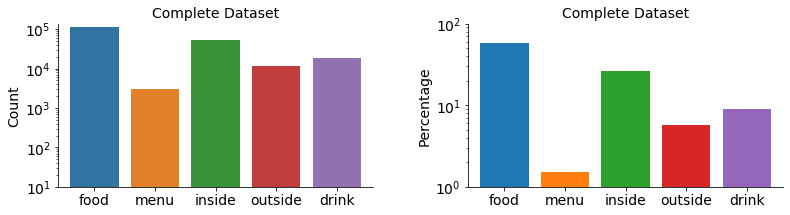

In [5]:
fig, ax = plt.subplots(figsize = (13,3))

#--------------------------------------#

ax1 = plt.subplot(121)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

sns.countplot(df_photos['label'])

ax1.set_yscale('log')
plt.title('Complete Dataset', fontsize = 14)
plt.xlabel('', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks([1e1, 1e2, 1e3, 1e4, 1e5], fontsize = 14)
plt.xlim(-0.6, 4.6)

#--------------------------------------#

ax2 = plt.subplot(122)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for i,v in enumerate(df_photos['label'].unique()):
    plt.bar(i, np.round(100 * (len(df_photos[df_photos['label'] == v].values) / df_photos.shape[0]), 2))

ax2.set_yscale('log')
plt.title('Complete Dataset', fontsize = 14)
plt.xlabel('', fontsize = 14)
plt.ylabel('Percentage', fontsize = 14)
plt.xticks(np.arange(0, len(df_photos['label'].unique()), 1), df_photos['label'].unique(), fontsize = 14)
plt.yticks([1e0, 1e1, 1e2], fontsize = 14)
plt.xlim(-0.6, 4.6)

#--------------------------------------#
              
plt.subplots_adjust(wspace = 0.3)
plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### Showing 9 random photos in the dataset

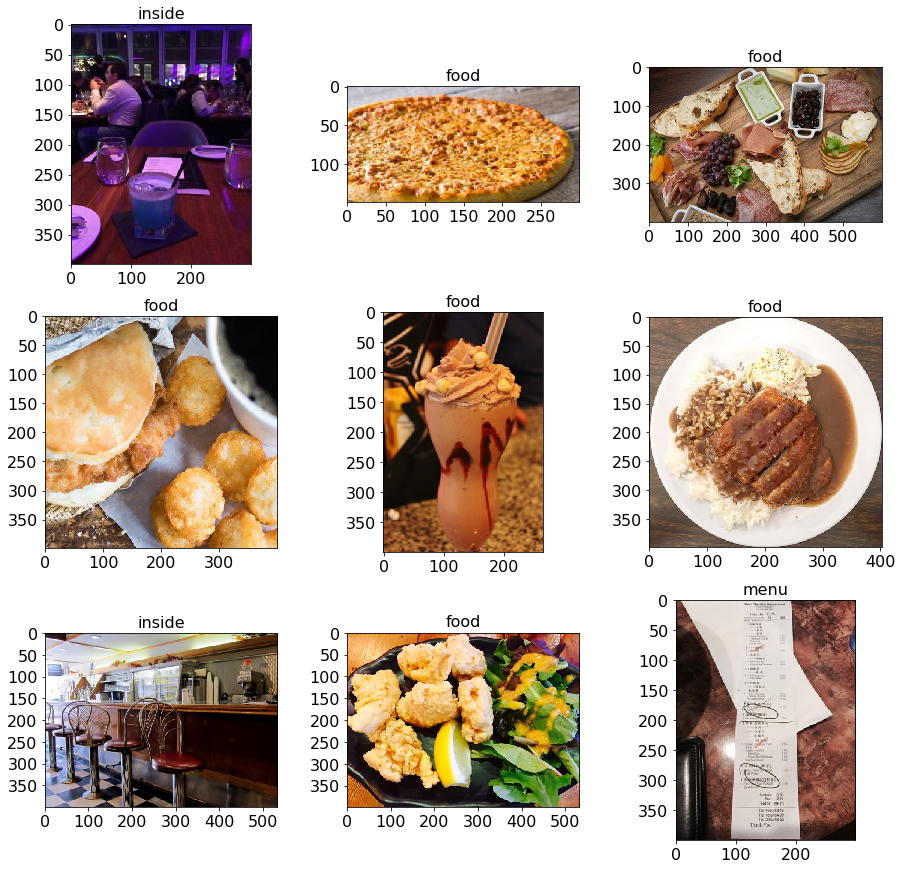

In [6]:
fig = plt.figure(figsize = (15,15))

#--------------------------------------------------------------------------------------------------------------------#

for i in range(9):
    
    r = random.randint(1, df_photos.shape[0])
    
    fig.add_subplot(3, 3, (i + 1))
    plt.title(df_photos.loc[r, 'label'], fontsize = 16)
    
    photo_i = cv2.cvtColor(cv2.imread("{}photos/{}.jpg".format(PHOTOS_PATHDIR, df_photos.loc[r,'photo_id'])), 
                           cv2.COLOR_BGR2RGB)
    plt.imshow(photo_i)
    
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    
#--------------------------------------------------------------------------------------------------------------------#
    
plt.subplots_adjust(wspace = 0.3)
plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SPLITTING THE DATASET IN TRAINING, VALIDATION AND TEST SETS

In [7]:
# training, validation and test dataframes that will be used by ImageDataGenerators.
df_photos_training = pd.DataFrame(columns = ['photo_id', 'label'])
df_photos_validation = pd.DataFrame(columns = ['photo_id', 'label'])
df_photos_test = pd.DataFrame(columns = ['photo_id', 'label'])

for lbl in df_photos['label'].unique():
    
    df = df_photos[df_photos['label'] == lbl]
    
    itrain, ival, itest = func_TrainValidationTest_Splitter(list_indexes = df.index.tolist(), 
                                                            test_percentage = TEST_PERCENTANGE, 
                                                            training_percentage = TRAINING_PERCENTANGE)
    
    df_photos_training = pd.concat([df_photos_training, df.loc[itrain, ['photo_id', 'label']]], sort = False)
    df_photos_validation = pd.concat([df_photos_validation, df.loc[ival, ['photo_id', 'label']]], sort = False)
    df_photos_test = pd.concat([df_photos_test, df.loc[itest, ['photo_id', 'label']]], sort = False)

#--------------------------------------------------------------------------------------------------------------------#

df_photos_training['photo_id'] = df_photos_training['photo_id'].values + '.jpg'
df_photos_validation['photo_id'] = df_photos_validation['photo_id'].values + '.jpg'
df_photos_test['photo_id'] = df_photos_test['photo_id'].values + '.jpg'

#--------------------------------------------------------------------------------------------------------------------#

if VERBOSE:
    print(">> COMPLETE DATASET (shape):    {}".format(df_photos.shape))
    print(">> TRAINING DATASET (shape):    {}".format(df_photos_training.shape))
    print(">> VALIDATION  DATASET (shape): {}".format(df_photos_validation.shape))
    print(">> TEST DATASET (shape):        {}".format(df_photos_test.shape))

>> COMPLETE DATASET (shape):    (200000, 4)
>> TRAINING DATASET (shape):    (74998, 2)
>> VALIDATION  DATASET (shape): (25003, 2)
>> TEST DATASET (shape):        (99999, 2)


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### Plotting the distribution of labels in the training, validation and test datasets.
#### (Notice that the proportions of labels is preserved)

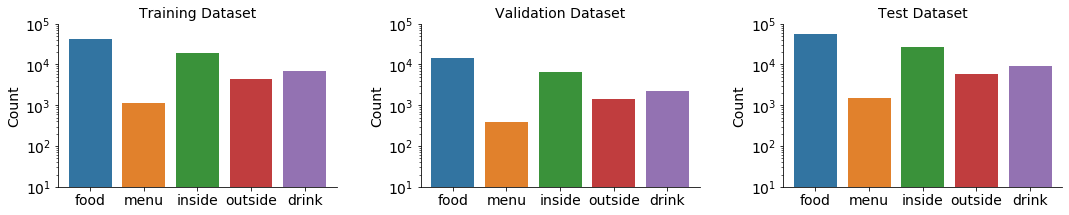

In [8]:
fig = plt.figure(figsize = (18,3))

#--------------------------------------------------------------------------------------------------------------------#

ax1 = plt.subplot(131)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

sns.countplot(df_photos_training['label'])

ax1.set_yscale('log')
plt.title('Training Dataset', fontsize = 14)
plt.xlabel('', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks([1e1, 1e2, 1e3, 1e4, 1e5], fontsize = 14)
plt.xlim(-0.6, 4.6)

#--------------------------------------#

ax2 = plt.subplot(132)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

sns.countplot(df_photos_validation['label'])

ax2.set_yscale('log')
plt.title('Validation Dataset', fontsize = 14)
plt.xlabel('', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks([1e1, 1e2, 1e3, 1e4, 1e5], fontsize = 14)
plt.xlim(-0.6, 4.6)

#--------------------------------------#

ax3 = plt.subplot(133)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

sns.countplot(df_photos_test['label'])

ax3.set_yscale('log')
plt.title('Test Dataset', fontsize = 14)
plt.xlabel('', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks([1e1, 1e2, 1e3, 1e4, 1e5], fontsize = 14)
plt.xlim(-0.6, 4.6)

#--------------------------------------------------------------------------------------------------------------------#

plt.subplots_adjust(wspace = 0.3)
plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SHUFFLING TRAINING, VALIDATION AND TEST DATAFRAMES

In [9]:
#shuffle the dataframes and reset the indexes
#df_photos_training = df_photos_training.sample(frac = 1.0, random_state = 0).reset_index(drop = True)
#df_photos_validation = df_photos_validation.sample(frac = 1.0, random_state = 0).reset_index(drop = True)
#df_photos_test = df_photos_test.sample(frac = 1.0, random_state = 0).reset_index(drop = True)

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### IF CLASSES_NUM = 3, THEN REMOVE THE PHOTS LABELED AS 'INSIDE' OR 'OUTSIDE',  AND PLOTTING THE RESULTING DISTRIBUTION OF LABELS

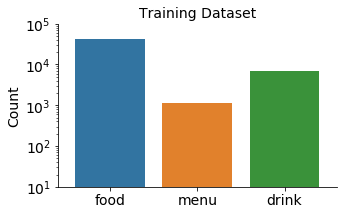

In [10]:
if CLASSES_NUM == 3:
    
    df_photos_training = df_photos_training[~df_photos_training['label'].isin(['inside', 'outside'])]
    df_photos_validation = df_photos_validation[~df_photos_validation['label'].isin(['inside', 'outside'])]
    df_photos_test = df_photos_test[~df_photos_test['label'].isin(['inside', 'outside'])]

    #----------------------------------------------------------------------------------------------------------------#

    fig, ax = plt.subplots(figsize = (5,3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    sns.countplot(df_photos_training['label'])

    ax.set_yscale('log')
    plt.title('Training Dataset', fontsize = 14)
    plt.xlabel('', fontsize = 14)
    plt.ylabel('Count', fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks([1e1, 1e2, 1e3, 1e4, 1e5], fontsize = 14)
    plt.xlim(-0.6, 2.6)

    plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### DEFINING THE IMAGE DATA GENERATORS AND CONSIDERING DATA AUGMENTATION

In [11]:
training_idg = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 45, 
                                  width_shift_range = 0.25, 
                                  height_shift_range = 0.25, 
                                  shear_range = 0.25, 
                                  zoom_range = 0.25, 
                                  horizontal_flip = True, 
                                  vertical_flip = True)

validation_idg = ImageDataGenerator(rescale = 1./255)
test_idg = ImageDataGenerator(rescale = 1./255)

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### VISUALIZING THE RESULTING DATA AUGMENTATION ON A RANDOMLY SELECTED PHOTO

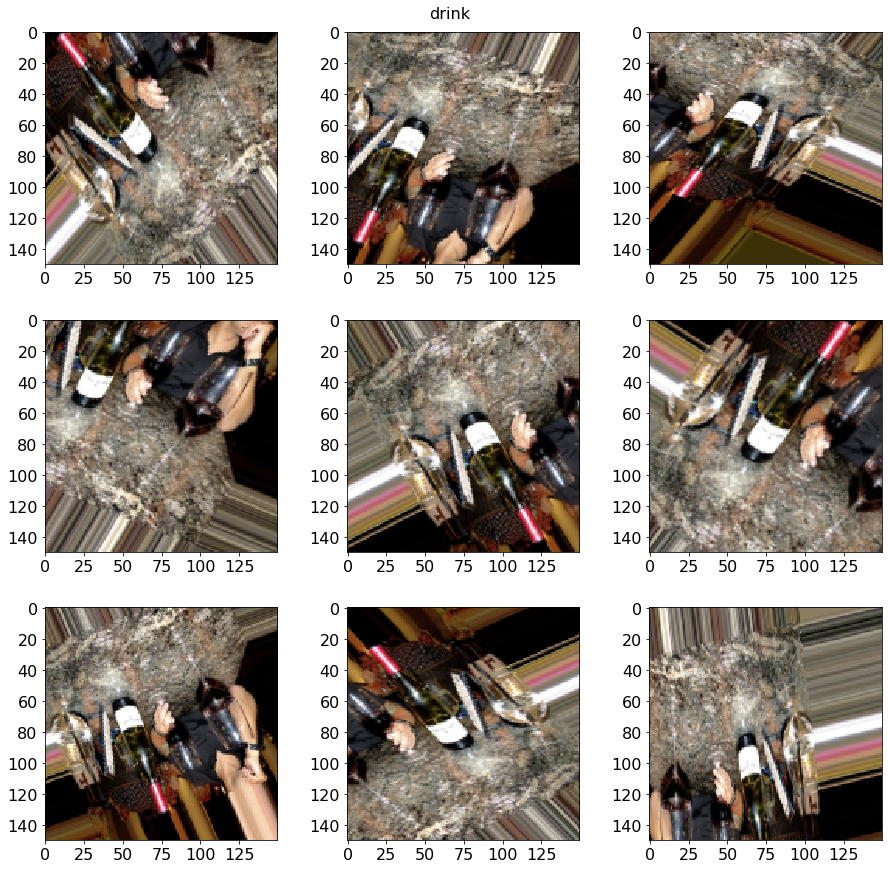

In [12]:
r = random.randint(1, df_photos_training.shape[0])

img = cv2.cvtColor(cv2.imread(PHOTOS_PATHDIR + 'photos/' + df_photos_training['photo_id'].values[r]), 
                   cv2.COLOR_BGR2RGB)
img = np.array(cv2.resize(img, PHOTO_SIZE))
img = img.reshape((1,) + img.shape)

fig = plt.figure(figsize = (15,15))
fig.suptitle(df_photos_training['label'].values[r], y = 0.9, fontsize = 16)

for i,batch in enumerate(training_idg.flow(img, batch_size = 1)):
    
    fig.add_subplot(3, 3, (i + 1))
    
    plt.imshow(batch[0])
    
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
        
    if i == 8:
        break
        
#--------------------------------------------------------------------------------------------------------------------#
    
plt.subplots_adjust(wspace = 0.3)
plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SETTING THE IMAGE DATA GENERATORS FROM DATAFRAMES

In [13]:
training_generator = training_idg.flow_from_dataframe(dataframe = df_photos_training, 
                                                      directory = PHOTOS_PATHDIR + 'photos/', 
                                                      x_col = 'photo_id', 
                                                      y_col = 'label', 
                                                      target_size = PHOTO_SIZE, 
                                                      color_mode = 'rgb',
                                                      class_mode = 'sparse', 
                                                      batch_size = BATCH_SIZE)

validation_generator = validation_idg.flow_from_dataframe(dataframe = df_photos_validation, 
                                                          directory = PHOTOS_PATHDIR + 'photos/', 
                                                          x_col = 'photo_id', 
                                                          y_col = 'label', 
                                                          target_size = PHOTO_SIZE, 
                                                          color_mode = 'rgb',
                                                          class_mode = 'sparse', 
                                                          batch_size = BATCH_SIZE)

test_generator = test_idg.flow_from_dataframe(dataframe = df_photos_test, 
                                              directory = PHOTOS_PATHDIR + 'photos/', 
                                              x_col = 'photo_id', 
                                              y_col = 'label', 
                                              target_size = PHOTO_SIZE, 
                                              color_mode = 'rgb',
                                              class_mode = 'sparse', 
                                              batch_size = BATCH_SIZE)

Found 51005 validated image filenames belonging to 3 classes.
Found 17005 validated image filenames belonging to 3 classes.
Found 68008 validated image filenames belonging to 3 classes.


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SEQUENTIAL MODEL DEFINITION

- if TRANSFER_LEARNING = True, some layers of the pretrained InceptionV3 model are used.
- if TRANSFER_LEARNING = False, a convolutional neural terwork is considered for classification. 

In [14]:
if TRANSFER_LEARNING:
    
    #STEP 1:
    pretrained_model = InceptionV3(weights = 'imagenet', 
                                   include_top = False, 
                                   input_shape = (PHOTO_SIZE[0], PHOTO_SIZE[1], 3))
    
    #-----------------------------------------------------------------------------#
    
    #STEP 2:
    for i, layer in enumerate(pretrained_model.layers):
        layer.trainable = False
        #print(i, layer.name)
        
    #-----------------------------------------------------------------------------#
    
    #STEP 3:
    if OUTPUT_LAYER == None:
        pretrained_model_output = pretrained_model.output
    else:
        pretrained_model_output = pretrained_model.get_layer(OUTPUT_LAYER).output

    print(">> OUTPUT (shape): {}\n".format(pretrained_model.get_layer(OUTPUT_LAYER).output_shape))
    
    #-----------------------------------------------------------------------------#
    
    x = pretrained_model_output
    
    #x = tf.keras.layers.Flatten(name = 'hlayer_1')(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name = 'hlayer_1')(x)
    
    x = tf.keras.layers.Dense(units = 512, 
                              activation = 'relu', 
                              kernel_regularizer = keras.regularizers.l2(REGULARIZATION_PARAM), 
                              name = 'hlayer_2')(x)
    
    x = tf.keras.layers.Dropout(rate = DROPOUT_RATE, name = 'hlayer_3')(x)
    
    predictions = tf.keras.layers.Dense(CLASSES_NUM, activation = 'softmax', name = 'hlayer_output')(x)

    model = Model(inputs = pretrained_model.input, outputs = predictions)
    
    model.compile(loss = 'sparse_categorical_crossentropy', 
                  metrics = ['sparse_categorical_accuracy'], 
                  optimizer = 'rmsprop')
    
else:

    model = tf.keras.models.Sequential([
    
        #Conv2D 1
        tf.keras.layers.Conv2D(filters = 16, 
                               kernel_size = (3,3), 
                               activation = 'relu', 
                               input_shape = (PHOTO_SIZE[0], PHOTO_SIZE[1], 3), 
                               name = 'hlayer_input'),

        tf.keras.layers.MaxPooling2D(pool_size = (2,2), name = 'hlayer_1'),

        #Conv2D 2
        tf.keras.layers.Conv2D(filters = 32, 
                               kernel_size = (3,3), 
                               activation = 'relu', 
                               name = 'hlayer_2'),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), name = 'hlayer_3'),

        #Conv2D 3
        tf.keras.layers.Conv2D(filters = 64, 
                               kernel_size = (3,3), 
                               activation = 'relu', 
                               name = 'hlayer_4'),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), name = 'hlayer_5'),

        #Conv2D 4
        tf.keras.layers.Conv2D(filters = 128, 
                               kernel_size = (3,3), 
                               activation = 'relu', 
                               name = 'hlayer_6'),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), name = 'hlayer_7'),

        tf.keras.layers.Flatten(name = 'hlayer_8'),
        #tf.keras.layers.GlobalAveragePooling2D(name = 'hlayer_8'),
        
        tf.keras.layers.Dense(units = 512, 
                              activation = 'relu', 
                              kernel_regularizer = keras.regularizers.l2(REGULARIZATION_PARAM), 
                              name = 'hlayer_9'),

        tf.keras.layers.Dense(units = 128, 
                              activation = 'relu', 
                              kernel_regularizer = keras.regularizers.l2(REGULARIZATION_PARAM), 
                              name = 'hlayer_10'),

        tf.keras.layers.Dropout(rate = DROPOUT_RATE, name = 'hlayer_11'),

        tf.keras.layers.Dense(CLASSES_NUM, activation = 'softmax', name = 'hlayer_output')
    ])
    
    model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = RMSprop(lr = LEARNING_RATE), 
                  metrics = ['sparse_categorical_accuracy'])

#--------------------------------------------------------------------------------------------------------------------#

model.summary()

>> OUTPUT (shape): (None, 3, 3, 1280)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________

__________________________________________________________________________________________________


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SEQUENTIAL MODEL TRAINING

In [15]:
%%time

if not os.path.isfile('model_IRC.h5'):

    history = model.fit_generator(training_generator,
                                  validation_data = validation_generator,
                                  steps_per_epoch = STEPS_PER_EPOCH,
                                  epochs = NUM_EPOCHS, 
                                  validation_steps = VALIDATION_STEPS,
                                  callbacks = [custom_Callback_sparse()],
                                  verbose = 1)
    
    #model.save("model_IRC.h5")
    #print("Trainned model saved to disk!")
    
else:
    
    model = load_model('model_IRC.h5')
    print("Trainned model loaded from disk!")

Epoch 1/50


W0806 11:19:33.527567 140737143739328 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


25/25 [==============================] - 251s 10s/step - loss: 5.0047 - sparse_categorical_accuracy: 0.8292 - val_loss: 3.0543 - val_sparse_categorical_accuracy: 0.8520
Epoch 2/50
25/25 [==============================] - 237s 9s/step - loss: 2.0734 - sparse_categorical_accuracy: 0.8696 - val_loss: 1.3219 - val_sparse_categorical_accuracy: 0.9064
Epoch 3/50
25/25 [==============================] - 185s 7s/step - loss: 1.0763 - sparse_categorical_accuracy: 0.8888 - val_loss: 0.9987 - val_sparse_categorical_accuracy: 0.8708
Epoch 4/50
25/25 [==============================] - 180s 7s/step - loss: 0.7220 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.6040 - val_sparse_categorical_accuracy: 0.9192
Epoch 5/50
25/25 [==============================] - 199s 8s/step - loss: 0.6239 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.4363 - val_sparse_categorical_accuracy: 0.9384
Epoch 6/50
25/25 [==============================] - 220s 9s/step - loss: 0.5240 - sparse_categorical_accuracy: 0.89

25/25 [==============================] - 217s 9s/step - loss: 0.2701 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.3235 - val_sparse_categorical_accuracy: 0.9320
Epoch 47/50
25/25 [==============================] - 225s 9s/step - loss: 0.3055 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.2702 - val_sparse_categorical_accuracy: 0.9368
Epoch 48/50
25/25 [==============================] - 238s 10s/step - loss: 0.3084 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.3427 - val_sparse_categorical_accuracy: 0.9188
Epoch 49/50
25/25 [==============================] - 231s 9s/step - loss: 0.3058 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.5389 - val_sparse_categorical_accuracy: 0.8816
Epoch 50/50
25/25 [==============================] - 238s 10s/step - loss: 0.2774 - sparse_categorical_accuracy: 0.9124 - val_loss: 0.3644 - val_sparse_categorical_accuracy: 0.9108
CPU times: user 8h 18min 21s, sys: 50min 28s, total: 9h 8min 50s
Wall time: 3h 12min 39s


<hr style="width:100%; height:10px; border:none; color:#ffffff; background-color:#000000;">

### PLOTTING MODEL PERFORMANCE DURING TRAINING

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

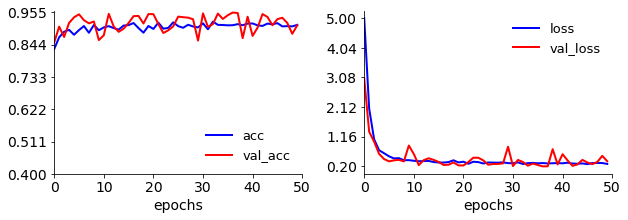

In [49]:
fig = plt.figure(figsize = (10,3))

#--------------------------------------------------------------------------------------------------------------------#

ax1 = plt.subplot(121)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.plot(np.arange(0,NUM_EPOCHS,1), history.history['sparse_categorical_accuracy'], 
         lw = 2, color = 'blue', label = 'acc')

plt.plot(np.arange(0,NUM_EPOCHS,1), history.history['val_sparse_categorical_accuracy'], 
         lw = 2, color = 'red', label = 'val_acc')

plt.xlabel('epochs', fontsize = 14)
plt.xticks(np.arange(0, (1.1 * NUM_EPOCHS), NUM_EPOCHS/5), fontsize = 14)
plt.xlim(0, NUM_EPOCHS)

miny = np.min([np.min(history.history['sparse_categorical_accuracy']), 
               np.min(history.history['val_sparse_categorical_accuracy'])])

maxy = np.max([np.max(history.history['sparse_categorical_accuracy']), 
               np.max(history.history['val_sparse_categorical_accuracy'])])

plt.yticks(np.round(np.arange(miny, (1.01 * maxy), (maxy - miny)/5), 3), fontsize = 14)
plt.legend(loc = 'lower right', frameon = False, fontsize = 13)

#----------------------------------------------------#

ax2 = plt.subplot(122)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.plot(np.arange(0, NUM_EPOCHS, 1), history.history['loss'], 
         lw = 2, color = 'blue', label = 'loss')

plt.plot(np.arange(0, NUM_EPOCHS, 1), history.history['val_loss'], 
         lw = 2, color = 'red', label = 'val_loss')

plt.xlabel('epochs', fontsize = 14)
plt.xticks(np.arange(0, (1.1 * NUM_EPOCHS), NUM_EPOCHS/5), fontsize = 14)
plt.xlim(0, NUM_EPOCHS)

miny = np.min([np.min(history.history['loss']), np.min(history.history['val_loss'])])
maxy = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])

plt.yticks(np.round(np.arange(miny, (1.1 * maxy), (maxy - miny)/5), 2), fontsize = 14)
plt.legend(loc = 'upper right', frameon = False, fontsize = 13)

#--------------------------------------------------------------------------------------------------------------------#

plt.subplots_adjust(wspace = 0.25)
plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### MODEL PERFORMANCE ON THE UNSEEN TEST DATA

In [18]:
loss_val, metric_val = model.evaluate_generator(generator = test_generator, verbose = 1)

681/681 [==============================] - 2882s 4s/step - loss: 0.3670 - sparse_categorical_accuracy: 0.9079


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### VISUALIZING OUTPUTS OF SOME INTERMEDIATE LAYERS (Conv2D and MaxPooling2D) FOR A GIVEN PHOTO, FOR ILUSTRATIVE PURPOSES ONLY FOR THE CASE TRANSFER_LEARNING = False

- step 1) visualization of an example photo manually selected for ilustrative purposes.

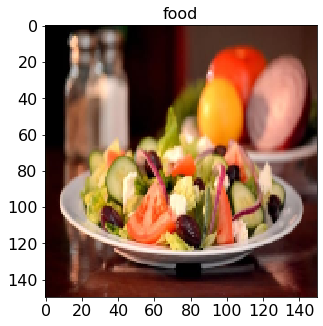

In [99]:
r = random.randint(1, len(df_photos_training.index))

ind = df_photos_training.index[r]
pid = df_photos_training.loc[ind, 'photo_id']

#--------------------------------------------------------------------------------------------------------------------#

img = cv2.cvtColor(cv2.imread("{}photos/{}".format(PHOTOS_PATHDIR, pid)), cv2.COLOR_BGR2RGB)
img = np.array(cv2.resize(img, PHOTO_SIZE))

#--------------------------------------------------------------------------------------------------------------------#

fig, ax = plt.subplots(figsize = (5,5))
plt.title(df_photos_training.loc[df_photos_training['photo_id'] == pid, 'label'].values[0], fontsize = 16)

plt.imshow(img)
    
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

<hr style="width:100%; height:10px; border:none; color:#ffffff; background-color:#000000;">

- step 2) storing the activation outputs of some intermediate layers on the selected photo.

In [100]:
layer_outputs = [layer.output for layer in model.layers[:8]]

img = img.reshape((1,) + img.shape)

activation_model = Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img)

<hr style="width:100%; height:10px; border:none; color:#ffffff; background-color:#000000;">

- step 3) plotting the activation outputs (i.e. identified features).

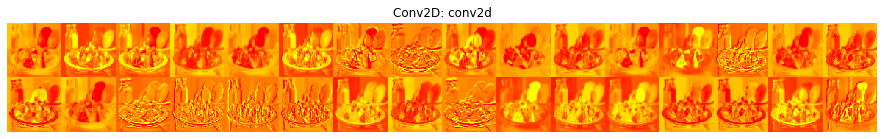

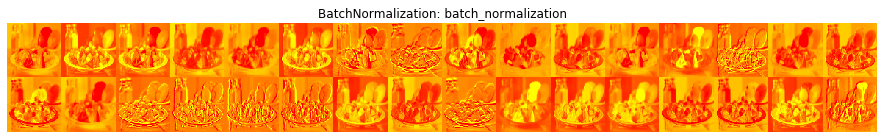

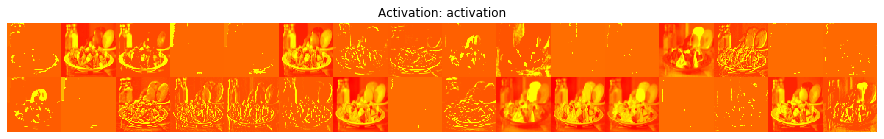

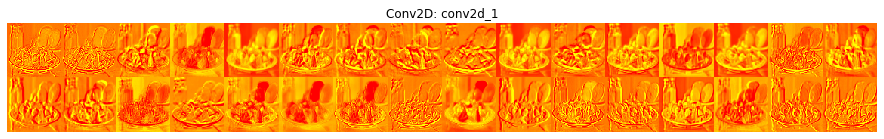

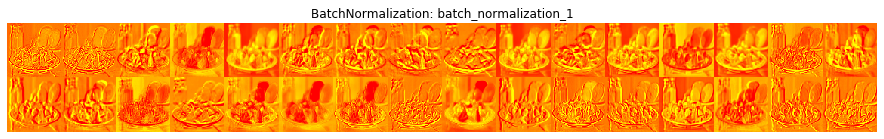

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


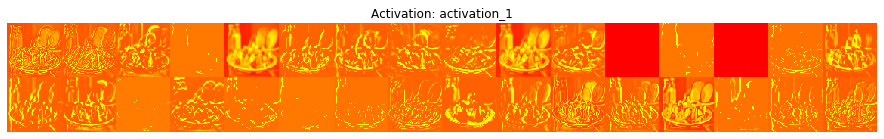

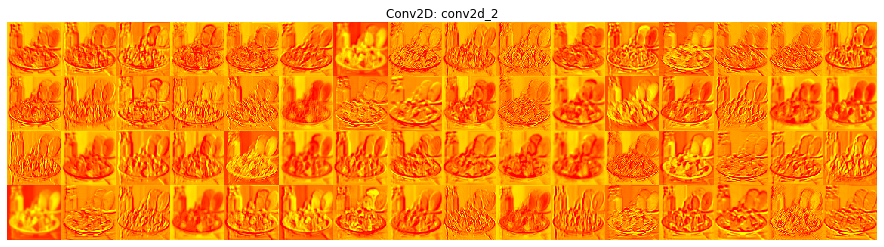

In [101]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(str(type(layer)).split('.')[-1].replace('\'>', '') + ": " + layer.name)
    
#--------------------------------------------------------------------------------------------------------------------#
    
#=> must be smaller or equal than the minimum n_filters in a Conv2D
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    
    #=> layer_activation.shape => output shape: (1, size, size, n_filters)
    
    n_filters = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_rows = n_filters // images_per_row
    
    display_grid = np.zeros((size * n_rows, images_per_row * size))
    
    for row in range(n_rows):
        for col in range(images_per_row):
            
            img_i = layer_activation[0,:,:, row * images_per_row + col]
            
            #=> Post-processes the feature to make it visually palatable
            img_i -= img_i.mean()
            img_i /= img_i.std()
            img_i *= 64
            img_i += 128
            img_i = np.clip(img_i, 0, 255).astype('uint8')
            
            display_grid[row * size : (row + 1) * size,
                         col * size : (col + 1) * size] = img_i
    
    #----------------------------------------------------------------------------------------------------------------#
    
    if display_grid.shape[0] != 0:
        
        plt.figure(figsize = ((1/size) * display_grid.shape[1], (1/size) * display_grid.shape[0]))
        plt.title(layer_name)

        plt.imshow(display_grid, cmap = 'autumn')

        plt.axis('off')
        plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### CALCULATING PHOTO SIZE STATISTICS

In [22]:
#%%time
#
#photos_xydim = []
#for pname in os.listdir('yelp_photos/photos/'):
#
#    p = np.array(cv2.imread("yelp_photos/photos/{}".format(pname)))
#    photos_xydim.append(p.shape)
#
#xdims = [dim[0] for dim in photos_xydim]
#print(">> Xdim => min: {} | max: {} | mean: {} | std: {}".format(np.min(xdims), 
#                                                                 np.max(xdims), 
#                                                                 np.mean(xdims),
#                                                                 np.std(xdims)))
#
#ydims = [dim[1] for dim in photos_xydim]
#print(">> Ydim => min: {} | max: {} | mean: {} | std: {}".format(np.min(ydims), 
#                                                                 np.max(ydims), 
#                                                                 np.mean(ydims),
#                                                                 np.std(ydims)))

# >> [OUTPUT]
# >> Xdim => min: 66 | max: 400 | mean: 389.88664 | std: 33.32757461187958
# >> Ydim => min: 62 | max: 600 | mean: 476.806665 | std: 124.16673719872716

In [23]:
#os.kill(os.getpid(), signal.SIGKILL)